# ETL Pipeline Preparation
Follow the instructions below to help you create your ETL (Extract, Transform, Load) pipeline.
### 1. Import libraries and load datasets.
- Import Python libraries
- Installation of a specific language library used for language detection
- Load `messages.csv` into a dataframe and inspect the first few lines.
- Load `categories.csv` into a dataframe and inspect the first few lines.

In [1]:
#
# import libraries
#
import numpy as np
import pandas as pd
import collections

# for storage of the cleaned dataset in a SQL database
from sqlalchemy import create_engine

# for language detection
from langdetect import detect, DetectorFactory

# for visualisation
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

#### `Messages` Dataset

In [2]:
# load messages dataset
try:
    messages = pd.read_csv('messages.csv')
except FileNotFoundError:
    print("The csv file 'messages.csv' does not exist in the given directory. No analysis possible.")
    
# success
print("The messages dataset has {} data points with {} variables each.".format(*messages.shape))

The messages dataset has 26248 data points with 4 variables each.


In [3]:
messages.head(10)

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct
5,14,Information about the National Palace-,Informtion au nivaux palais nationl,direct
6,15,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct
7,16,"Please, we need tents and water. We are in Sil...",Tanpri nou bezwen tant avek dlo nou zon silo m...,direct
8,17,"I would like to receive the messages, thank you",Mwen ta renmen jouin messag yo. Merci,direct
9,18,I am in Croix-des-Bouquets. We have health iss...,"Nou kwadebouke, nou gen pwoblem sant m yo nan ...",direct


In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 4 columns):
id          26248 non-null int64
message     26248 non-null object
original    10184 non-null object
genre       26248 non-null object
dtypes: int64(1), object(3)
memory usage: 820.3+ KB


<b>Note:</b><br>
Now, we are doing some more exploratory data analysis on this messages dataset, regarding the following questions:
- What kind of genre exists?
- As we can see from the information above, there are original languages, means not all messages are originally in English. But having 26248 entries altogether and also 26248 message items, we have to proof if all this message items are in English, means it is expected that the original messages are translated properly. Have in mind that for simplification of this project, only English text messages are investigated.

##### Genre

In [5]:
# genre values
messages['genre'].unique()

array(['direct', 'social', 'news'], dtype=object)

In [6]:
genre = messages.groupby('genre').size()
dict_genre = genre.to_dict()
dict_genre

{'direct': 10782, 'news': 13068, 'social': 2398}

<b>Note:</b> The genre of the messages before cleaning is grouped in:<br>
- 2398 social messages
- 10782 direct messages
- 13068 news messages

##### Languages
The next topic are the languages: Are all message texts in English? They shall be used for text analysis. The indexing shall not be changed, because this analysis happened before both datasets are merged. Language coding interpretation can be found on the following [website](https://www.loc.gov/standards/iso639-2/php/code_list.php).

In [7]:
# see: https://pypi.org/project/langdetect/
# Language detection algorithm is non-deterministic, which means that if you try to run it on a text which is either
# too short or too ambiguous, you might get different results everytime you run it.
# Therefore the DetectorFactory.seed is necessary.

DetectorFactory.seed = 14

def select_language_codes(df_source):
    message_subset = df_source['message']
    languages = []
    for message in message_subset.values:  # [100:120]:  note: index 117: French message
        try:
            if message in (None, ''):
                lang_code = None
            else:
                lang_code = detect(message)
        except:
            lang_code = None
        languages.append(lang_code)
        #print("message: {} - lang_code: {}".format(message, lang_code))
        
    return languages

In [8]:
languages = select_language_codes(messages)

In [9]:
messages['lang_code'] = languages
messages.head(120)

,id,message,original,genre,lang_code
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,en
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,en
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,no
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,en
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,en
5,14,Information about the National Palace-,Informtion au nivaux palais nationl,direct,en
6,15,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,en
7,16,"Please, we need tents and water. We are in Sil...",Tanpri nou bezwen tant avek dlo nou zon silo m...,direct,en
8,17,"I would like to receive the messages, thank you",Mwen ta renmen jouin messag yo. Merci,direct,en
9,18,I am in Croix-des-Bouquets. We have health iss...,"Nou kwadebouke, nou gen pwoblem sant m yo nan ...",direct,en


<b>Note:</b><br>
We realise that the language decoder software has some weakness analysing the message text values, because e.g. the index row 117 is properly mapped to coding 'fr' for French, but index row 2 is incorrectly mapped to 'no' - Norwegian language - instead of correct 'en' coding for English.

In [10]:
messages.shape

(26248, 5)

In [11]:
messages['lang_code'].unique()

array(['en', 'no', 'af', 'nl', 'cy', 'fr', 'ca', 'de', 'es', 'tl', 'et',
       'pt', 'da', 'it', 'fi', 'so', 'hu', 'vi', 'tr', 'sl', 'pl', 'id',
       'sq', 'sw', None, 'ro', 'hr', 'sv', 'sk'], dtype=object)

In [12]:
messages['lang_code'].value_counts()

en    25829
fr       57
de       54
pt       35
id       34
nl       32
af       30
so       28
es       23
it       18
da       16
vi       13
ca       12
tl       10
no        8
et        7
sq        7
cy        6
sw        5
tr        4
fi        3
pl        3
sv        3
sl        2
hr        1
hu        1
sk        1
ro        1
Name: lang_code, dtype: int64

In [13]:
# proof if the language detection is correctly mapped to the associated message text
messages.query('lang_code == "pl"')

,id,message,original,genre,lang_code
5978,6802,gjm.adgjmpgjm.adgjmgjmgjmgjmgjmgkmptwptwptwptw...,gjm. adgjmpgjm. adgjmgjmgjmgjmgjmgkmptwptwptwp...,direct,pl
8154,9141,/''''''''@''''''''''''''''@ @''''' michou )) '...,/''''''''@''''''''''''''''@ @''''' michou ) ) ...,direct,pl
8174,9162,/''''''''@''''''''''''''''@ @''''' michou )) '...,/''''''''@''''''''''''''''@ @''''' michou ) ) ...,direct,pl


This 'nonsense' text messages are wrongly classified to be Polish language.

<b>Note:</b><br>
We realise there are rows having no English message. As listed, there are several languages used. As one root cause, the original message of the different language is not translated. Another possible case could be that the message value is an empty string or that an exception appeared during language code detection. For this last-mentioned cases the feature value of the language code is set to 'None'. 

Another reason is as seen above, that 'nonsense' text messages exists somewhere in the dataset. If they are mapped to another language then English, fine, they will be part of the cleaning process. If there are still 'en' classified text messages which are 'nonsense', we have to take care during the NLP pipeline, e.g. by usage of regular expressions.

Additionally, there could be other language coding issues, which may lead the message text to be mapped to a different language coding than English code 'en':<br>
- misspellings in the message text items
- the message text is e.g. a web link or an abbreviation sequence
- e.g. the original text message is in Frensh and as far as it can be seen correctly translated in English. So, the language coding library could lead to a wrong mapping of the message language code because of software weakness. It should be 'en', but the detection library has selected a different one.
- there is no original text (value is set to NaN, means None in this case), and the message text is directly stored in the message column, even being in a different language compared to English

In this project part, this both non-English row cases - different language or None message value - are removed from the dataset as cleaning step after the merge of messages and categories datasets. Regarding the found text issues, this is a simplifiction which in reality needs further 'toDo'. It is possible that rows are removed which are correctly translated to English. We expect that this amount is not a huge one and accept it, because there are still more than 25000 'en' items.

<b>Remark:</b><br>
We have in mind, that there is probably a more reliable language coding library. Unfortunately, <i>polyglot</i> and <i>spacy</i> including all dependencies could not be installed only by using simple <i>conda</i> or <i>pip</i> commands on a Windows OS machine on terminal level. Perhaps their language detector coding is much better, but because of the project timeframe this is a future follow-up task.

#### `Categories` Dataset

In [14]:
# load categories dataset
try:
    categories = pd.read_csv('categories.csv')
except FileNotFoundError:
    print("The csv file 'categories.csv' does not exist in the given directory. No analysis possible.")  
    
# Success
print("The categories dataset has {} data points with {} variables each.".format(*categories.shape))

The categories dataset has 26248 data points with 2 variables each.


In [15]:
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


In [16]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 2 columns):
id            26248 non-null int64
categories    26248 non-null object
dtypes: int64(1), object(1)
memory usage: 410.2+ KB


Note: It is obvious that we have to do some cleaning here, this happens below after merging.

### 2. Merge datasets.
- Merge the messages and categories datasets using the common id
- Assign this combined dataset to `df`, which will be cleaned in the following steps

In [17]:
messages['id'].equals(categories['id'])

True

In [18]:
# merge datasets
df = messages.merge(categories, on='id')
df.head()

,id,message,original,genre,lang_code,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,en,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,en,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,no,related-1;request-0;offer-0;aid_related-0;medi...
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,en,related-1;request-1;offer-0;aid_related-1;medi...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,en,related-1;request-0;offer-0;aid_related-0;medi...


### 3. Split `categories` into separate category columns.
- Split the values in the `categories` column on the `;` character so that each value becomes a separate column. You'll find [this method](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.str.split.html) very helpful! Make sure to set `expand=True`.
- Use the first row of categories dataframe to create column names for the categories data.
- Rename columns of `categories` with new column names.

In [19]:
# create a dataframe of the 36 individual category columns
categories = categories['categories'].str.split(pat=";", expand=True)
categories.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [20]:
# select the first row of the categories dataframe
row = categories.head(1).values
row

array([['related-1', 'request-0', 'offer-0', 'aid_related-0',
        'medical_help-0', 'medical_products-0', 'search_and_rescue-0',
        'security-0', 'military-0', 'child_alone-0', 'water-0', 'food-0',
        'shelter-0', 'clothing-0', 'money-0', 'missing_people-0',
        'refugees-0', 'death-0', 'other_aid-0',
        'infrastructure_related-0', 'transport-0', 'buildings-0',
        'electricity-0', 'tools-0', 'hospitals-0', 'shops-0',
        'aid_centers-0', 'other_infrastructure-0', 'weather_related-0',
        'floods-0', 'storm-0', 'fire-0', 'earthquake-0', 'cold-0',
        'other_weather-0', 'direct_report-0']], dtype=object)

In [21]:
# use this row to extract a list of new column names for categories.
# one way is to apply a lambda function that takes everything 
# up to the second to last character of each string with slicing

category_colnames = []
# the row variable itself has length 1, but the one row has 36 category elements
for i in range(len(row[0])):
    s = pd.Series([row[0][i]])
    colname = s.str.split(pat='-', n=1)
    category_colnames.append(colname[0][0])
    
print(category_colnames)

['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


In [22]:
# rename the columns of `categories`
categories.columns = category_colnames
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


### 4. Convert category values to just numbers 0 or 1.
- Iterate through the category columns in df to keep only the last character of each string (the 1 or 0). For example, `related-0` becomes `0`, `related-1` becomes `1`. Convert the string to a numeric value.
- You can perform [normal string actions on Pandas Series](https://pandas.pydata.org/pandas-docs/stable/text.html#indexing-with-str), like indexing, by including `.str` after the Series. You may need to first convert the Series to be of type string, which you can do with `astype(str)`.

In [23]:
for column in categories:
    # set each value to be the last character of the string
    # convert column from string to numeric
    categories[column] =  categories[column].str.split("-").str[1].astype('int64')

categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 36 columns):
related                   26248 non-null int64
request                   26248 non-null int64
offer                     26248 non-null int64
aid_related               26248 non-null int64
medical_help              26248 non-null int64
medical_products          26248 non-null int64
search_and_rescue         26248 non-null int64
security                  26248 non-null int64
military                  26248 non-null int64
child_alone               26248 non-null int64
water                     26248 non-null int64
food                      26248 non-null int64
shelter                   26248 non-null int64
clothing                  26248 non-null int64
money                     26248 non-null int64
missing_people            26248 non-null int64
refugees                  26248 non-null int64
death                     26248 non-null int64
other_aid                 26248 non-null int6

So, all feature values are integers, means they have the expected data type and all items are filled with a value. But are all integer values are only 0 or 1?

In [25]:
categories.describe()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.0,...,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000,26248.000000
mean,0.774002,0.170680,0.004534,0.414432,0.079511,0.050061,0.027583,0.017944,0.032764,0.0,...,0.011772,0.043851,0.278269,0.082216,0.093264,0.010744,0.093531,0.020192,0.052423,0.193577
std,0.435472,0.376236,0.067181,0.492633,0.270540,0.218075,0.163778,0.132751,0.178023,0.0,...,0.107862,0.204767,0.448155,0.274698,0.290808,0.103095,0.291181,0.140659,0.222883,0.395108
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<b>Note:</b><br>
Surprisingly, for the column related the maximum value is 2. Expected is only 0 and 1 for this feature: if the feature has the value 1, the message is classified to be a disaster message. If it is 0, all other features shall have the value 0, which finally means the message is not a disaster message.

So, we will explore the column related more detailed now.

In [26]:
categories['related'].value_counts(sort=False)

0     6125
1    19930
2      193
Name: related, dtype: int64

In [27]:
df_related_2 = categories.query('related == 2')
df_related_2.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
117,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
305,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
460,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
576,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, visualise the different category content values '0', '1' and '2' for each category. Are there other columns having values greater 1? If the dictionary value lists for the other features include only the two integer values (counts of content 0 and 1), the answer is no.

In [28]:
category_content_names = ['0', '1', '2']

dict_category_content_values = {}
categories_columns = sorted(categories.columns)
for column in categories_columns:
    dict_category_content_values[column] = categories[column].value_counts(sort=False).values.tolist()
print(dict_category_content_values)

{'aid_centers': [25939, 309], 'aid_related': [15370, 10878], 'buildings': [24913, 1335], 'child_alone': [26248], 'clothing': [25842, 406], 'cold': [25718, 530], 'death': [25052, 1196], 'direct_report': [21167, 5081], 'earthquake': [23793, 2455], 'electricity': [25714, 534], 'fire': [25966, 282], 'floods': [24090, 2158], 'food': [23318, 2930], 'hospitals': [25965, 283], 'infrastructure_related': [24543, 1705], 'medical_help': [24161, 2087], 'medical_products': [24934, 1314], 'military': [25388, 860], 'missing_people': [25949, 299], 'money': [25644, 604], 'offer': [26129, 119], 'other_aid': [22800, 3448], 'other_infrastructure': [25097, 1151], 'other_weather': [24872, 1376], 'refugees': [25372, 876], 'related': [6125, 19930, 193], 'request': [21768, 4480], 'search_and_rescue': [25524, 724], 'security': [25777, 471], 'shelter': [23929, 2319], 'shops': [26128, 120], 'storm': [23800, 2448], 'tools': [26089, 159], 'transport': [25045, 1203], 'water': [24574, 1674], 'weather_related': [18944,

In [29]:
#labels = list(dict_category_content_values.keys())
#labels

In [30]:
#data = list(dict_category_content_values.values())
#pd.DataFrame(data=data).cumsum(axis=1)

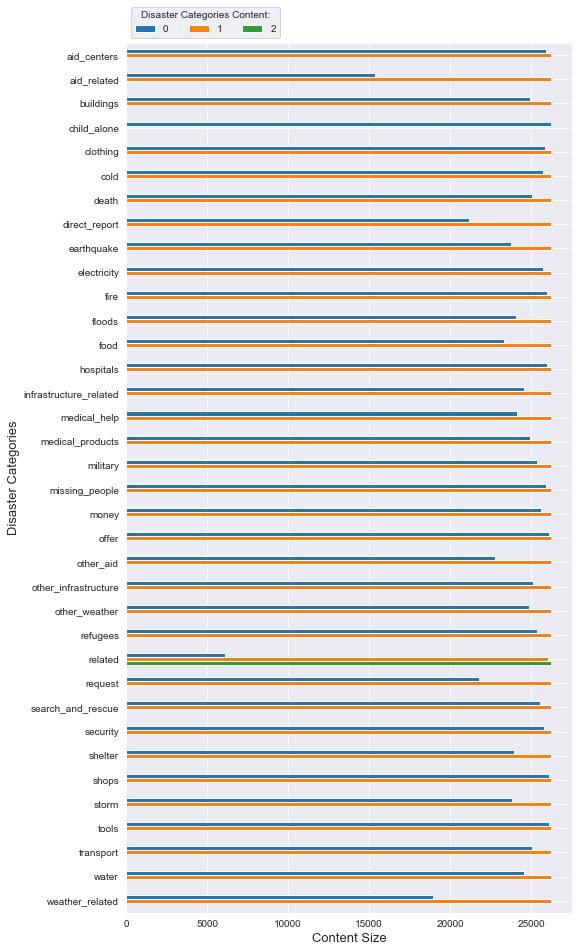

In [31]:
# Visualise the amount of each category content 0, 1 or 2
index = list(dict_category_content_values.keys())
data = list(dict_category_content_values.values())
df_cat = pd.DataFrame(data=data, index=index).cumsum(axis=1)
ax = df_cat.plot.barh(figsize=[8,16])  # Figure dimension (width, height) in inches
ax.set_xlabel('Content Size', fontsize=13)
ax.set_ylabel('Disaster Categories', fontsize=13)
ax.invert_yaxis()
ax.legend(ncol=len(category_content_names), bbox_to_anchor=(0, 1),
          loc='lower left', fontsize=10, title='Disaster Categories Content:')

<b>Note:</b><br>
As we can see, there is only one column including the content 2, this column is called 'related'.<br>
Additionally, the column 'child_alone' is the only one, including only one bar for the content 0. But this seems not reliable, because in a disaster situation there are probably children which are alone without other family members.

This needs some more investigation, starting with the question why exists a related value of 2? What does it mean?

First, we will clarify what are the values of the other row category features regarding the items with related category feature is 2. The 5 examples rows above let us assume that the other category values are always 0. We have to validate this assumption. 

In [32]:
dict_df_related_2 = {}
for column in df_related_2.columns:
    dict_df_related_2[column] = df_related_2[column].unique()

In [33]:
dict_df_related_2

{'related': array([2], dtype=int64),
 'request': array([0], dtype=int64),
 'offer': array([0], dtype=int64),
 'aid_related': array([0], dtype=int64),
 'medical_help': array([0], dtype=int64),
 'medical_products': array([0], dtype=int64),
 'search_and_rescue': array([0], dtype=int64),
 'security': array([0], dtype=int64),
 'military': array([0], dtype=int64),
 'child_alone': array([0], dtype=int64),
 'water': array([0], dtype=int64),
 'food': array([0], dtype=int64),
 'shelter': array([0], dtype=int64),
 'clothing': array([0], dtype=int64),
 'money': array([0], dtype=int64),
 'missing_people': array([0], dtype=int64),
 'refugees': array([0], dtype=int64),
 'death': array([0], dtype=int64),
 'other_aid': array([0], dtype=int64),
 'infrastructure_related': array([0], dtype=int64),
 'transport': array([0], dtype=int64),
 'buildings': array([0], dtype=int64),
 'electricity': array([0], dtype=int64),
 'tools': array([0], dtype=int64),
 'hospitals': array([0], dtype=int64),
 'shops': array([0

In [34]:
# remove the category feature 'related' from this subset, we are only interested on the other categories
del dict_df_related_2['related']

In [35]:
related2_keys = list(dict_df_related_2.keys())
related2_values = list(dict_df_related_2.values())

for i in range(len(related2_keys)):
    print("{} has value(s) {}".format(related2_keys[i], related2_values[i]))

request has value(s) [0]
offer has value(s) [0]
aid_related has value(s) [0]
medical_help has value(s) [0]
medical_products has value(s) [0]
search_and_rescue has value(s) [0]
security has value(s) [0]
military has value(s) [0]
child_alone has value(s) [0]
water has value(s) [0]
food has value(s) [0]
shelter has value(s) [0]
clothing has value(s) [0]
money has value(s) [0]
missing_people has value(s) [0]
refugees has value(s) [0]
death has value(s) [0]
other_aid has value(s) [0]
infrastructure_related has value(s) [0]
transport has value(s) [0]
buildings has value(s) [0]
electricity has value(s) [0]
tools has value(s) [0]
hospitals has value(s) [0]
shops has value(s) [0]
aid_centers has value(s) [0]
other_infrastructure has value(s) [0]
weather_related has value(s) [0]
floods has value(s) [0]
storm has value(s) [0]
fire has value(s) [0]
earthquake has value(s) [0]
cold has value(s) [0]
other_weather has value(s) [0]
direct_report has value(s) [0]


<b>Note:</b><br>
Our former assumption that all other category values are 0 is true. Means the associated message is not a disaster message and the value 2 is probably a mistake. Therefore, we change it to be 0 instead of 2.

In [36]:
categories['related'].replace([2], 0, inplace=True)

In [37]:
# Test if only 0 and 1 appeared as 'related' feature values
categories['related'].value_counts()

1    19930
0     6318
Name: related, dtype: int64

Now, we have to proof if all rows with related value 0, have only associated features with value 0.

In [38]:
df_related_0 = categories.query('related == 0')
dict_df_related_0 = {}
for column in df_related_0.columns:
    dict_df_related_0[column] = df_related_0[column].unique()

In [39]:
dict_df_related_0

{'related': array([0], dtype=int64),
 'request': array([0], dtype=int64),
 'offer': array([0], dtype=int64),
 'aid_related': array([0], dtype=int64),
 'medical_help': array([0], dtype=int64),
 'medical_products': array([0], dtype=int64),
 'search_and_rescue': array([0], dtype=int64),
 'security': array([0], dtype=int64),
 'military': array([0], dtype=int64),
 'child_alone': array([0], dtype=int64),
 'water': array([0], dtype=int64),
 'food': array([0], dtype=int64),
 'shelter': array([0], dtype=int64),
 'clothing': array([0], dtype=int64),
 'money': array([0], dtype=int64),
 'missing_people': array([0], dtype=int64),
 'refugees': array([0], dtype=int64),
 'death': array([0], dtype=int64),
 'other_aid': array([0], dtype=int64),
 'infrastructure_related': array([0], dtype=int64),
 'transport': array([0], dtype=int64),
 'buildings': array([0], dtype=int64),
 'electricity': array([0], dtype=int64),
 'tools': array([0], dtype=int64),
 'hospitals': array([0], dtype=int64),
 'shops': array([0

Fine, all values are correctly set to 0, means no related value 0 is set incorrectly. For this topic, no cleaning is necessary.

### 5. Replace `categories` column in `df` with new category columns.
- Drop the categories column from the df dataframe since it is no longer needed.
- Concatenate df and categories data frames.

In [40]:
# drop the original categories column from `df`
df.drop(columns=['categories'], inplace=True)
df.head()

,id,message,original,genre,lang_code
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,en
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,en
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,no
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,en
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,en


In [41]:
# concatenate the original dataframe with the new `categories` dataframe
df = df.merge(categories, left_index=True, right_index=True)
df.head()

,id,message,original,genre,lang_code,related,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,en,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,en,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,no,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,en,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,en,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26248 entries, 0 to 26247
Data columns (total 41 columns):
id                        26248 non-null int64
message                   26248 non-null object
original                  10246 non-null object
genre                     26248 non-null object
lang_code                 26243 non-null object
related                   26248 non-null int64
request                   26248 non-null int64
offer                     26248 non-null int64
aid_related               26248 non-null int64
medical_help              26248 non-null int64
medical_products          26248 non-null int64
search_and_rescue         26248 non-null int64
security                  26248 non-null int64
military                  26248 non-null int64
child_alone               26248 non-null int64
water                     26248 non-null int64
food                      26248 non-null int64
shelter                   26248 non-null int64
clothing                  26248 non-null 

### 6. Remove duplicates and Non-English items
- Check how many duplicates are in this dataset
- Drop the duplicates
- Confirm duplicates were removed
- Detect the language code of the message column
- Filter only having the 'en' English rows
- Check that only 'en' language coding is available

##### Duplicates

In [43]:
# check number of duplicates
sum(df.duplicated())

43

In [44]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [45]:
# check number of duplicates
sum(df.duplicated())

0

In [46]:
print("After removing the duplicate items, the dataframe includes {} rows.".format(df.shape[0]))

After removing the duplicate items, the dataframe includes 26205 rows.


##### Non-English messages

In [47]:
df['lang_code'].value_counts()

en    25783
fr       59
de       54
pt       35
id       34
nl       32
af       30
so       29
es       23
it       18
da       16
vi       13
ca       12
tl       10
no        8
et        7
sq        7
cy        6
sw        5
tr        4
fi        3
pl        3
sv        3
sl        2
hr        1
hu        1
sk        1
ro        1
Name: lang_code, dtype: int64

In [48]:
df['lang_code'].unique()

array(['en', 'no', 'af', 'nl', 'cy', 'fr', 'ca', 'de', 'es', 'tl', 'et',
       'pt', 'da', 'it', 'fi', 'so', 'hu', 'vi', 'tr', 'sl', 'pl', 'id',
       'sq', 'sw', None, 'ro', 'hr', 'sv', 'sk'], dtype=object)

In [49]:
df_en = df.query('lang_code == "en"')
df_en['lang_code'].unique()

array(['en'], dtype=object)

Now, after we have created our cleaned dataset, we continue to work with it. First, delivering some general data information in the next chapter.

### 7. Information of the cleaned dataset
##### In general

In [50]:
print("The cleaned dataset has {} data points with {} variables each.".format(*df_en.shape))

The cleaned dataset has 25783 data points with 41 variables each.


In [51]:
df_en.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,25783.000000,25783.000000,25783.000000,25783.000000,25783.000000,25783.00000,25783.000000,25783.000000,25783.000000,25783.000000,...,25783.000000,25783.000000,25783.000000,25783.000000,25783.00000,25783.000000,25783.000000,25783.000000,25783.000000,25783.000000
mean,15222.507156,0.761510,0.169647,0.004538,0.416127,0.08013,0.050304,0.027848,0.018113,0.033239,...,0.011946,0.044060,0.279719,0.082613,0.09386,0.010937,0.093938,0.020479,0.052981,0.192569
std,8797.986777,0.426169,0.375329,0.067212,0.492925,0.27150,0.218577,0.164540,0.133362,0.179263,...,0.108644,0.205233,0.448870,0.275301,0.29164,0.104011,0.291748,0.141633,0.223999,0.394325
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7452.500000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15786.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22902.500000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30111.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Some visualisation
Now, after cleaning and in general, how many items are a disaster message the organisations have to react on and how many are not?

In [52]:
def plot_feature_bar(dict, titel, xlabel, ylabel, labels, figsize):
    # plot the dictionary keys as x params and the dictionary values as y params for the bar chart
    sorted_feature = sorted(dict.items(), key=lambda kv: kv[1])
    dict_sorted = collections.OrderedDict(sorted_feature)
    if labels in [None]:
        labels = list(dict_sorted.keys())
    values = list(dict_sorted.values())

    fig, ax = plt.subplots(figsize=figsize)
    plt.xticks(rotation=90)
    ax.bar(labels, values, alpha=0.8)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set
    fig.suptitle(titel)

In [53]:
dict_disaster_related = df_en.groupby('related').size().to_dict()
dict_disaster_related

{0: 6149, 1: 19634}

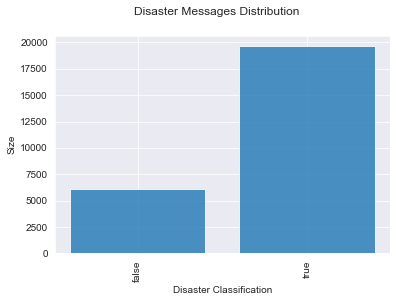

In [54]:
plot_feature_bar(dict_disaster_related,
                 'Disaster Messages Distribution', 'Disaster Classification', 'Size', ['false', 'true'], None)

Above in project chapter 1, we have analysed the available genre types and their numerical amount before cleaning. Now, this distribution is visualised after cleaning of the merged dataset.

In [55]:
dict_df_genre = df_en.groupby('genre').size().to_dict()
dict_df_genre

{'direct': 10511, 'news': 12943, 'social': 2329}

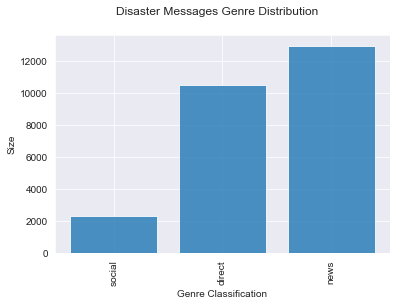

In [56]:
plot_feature_bar(dict_df_genre, 'Disaster Messages Genre Distribution', 'Genre Classification', 'Size', None, None)

What is the distribution of the category features? If it is a disaster - means related is set to 1 - at least one of the other category features must have an attribute value of 1. We know already that the category 'child_alone' is not part of the disaster messages, there only zero values appeared.

In [57]:
cat_list = []
for i in range(36):
    cat_list.append(categories.columns[i])

del cat_list[0]
cat_list

['request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [58]:
df_related_1 = df_en.query("related == 1")

In [59]:
dict_cat = {}
for cat in cat_list:
    dict_df_cat = df_related_1.groupby(cat).size().to_dict()
    if len(dict_df_cat) > 1:
        dict_cat[cat] = dict_df_cat[1]
    
dict_cat

{'request': 4374,
 'offer': 117,
 'aid_related': 10729,
 'medical_help': 2066,
 'medical_products': 1297,
 'search_and_rescue': 718,
 'security': 467,
 'military': 857,
 'water': 1650,
 'food': 2885,
 'shelter': 2281,
 'clothing': 401,
 'money': 598,
 'missing_people': 297,
 'refugees': 872,
 'death': 1187,
 'other_aid': 3392,
 'infrastructure_related': 1688,
 'transport': 1197,
 'buildings': 1313,
 'electricity': 528,
 'tools': 158,
 'hospitals': 283,
 'shops': 118,
 'aid_centers': 308,
 'other_infrastructure': 1136,
 'weather_related': 7212,
 'floods': 2130,
 'storm': 2420,
 'fire': 282,
 'earthquake': 2422,
 'cold': 528,
 'other_weather': 1366,
 'direct_report': 4965}

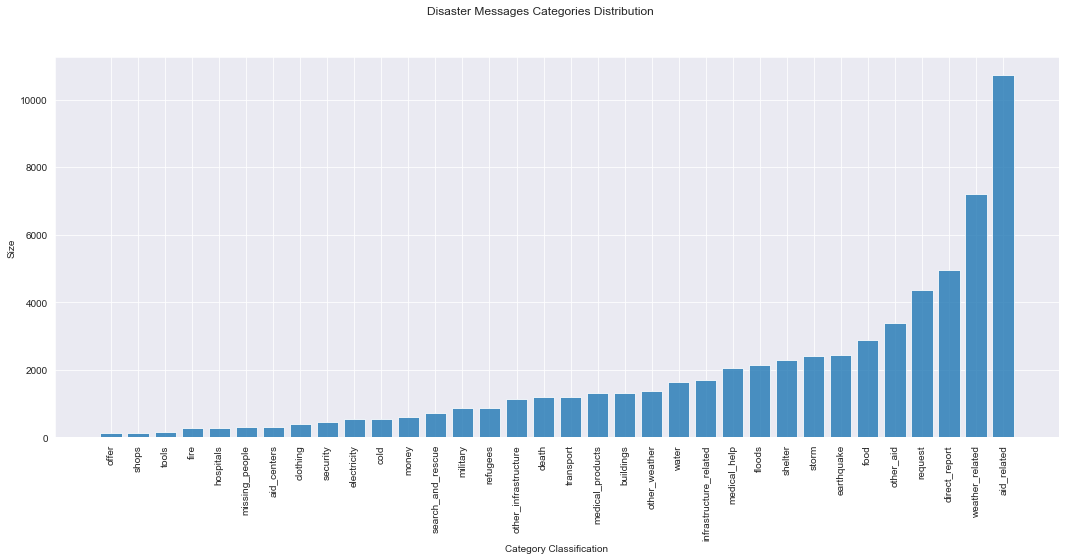

In [60]:
plot_feature_bar(dict_cat, 'Disaster Messages Categories Distribution', 'Category Classification', 'Size', None, (18, 7))

### 8. Save the clean dataset into an sqlite database.
You can do this with pandas [`to_sql` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_sql.html) combined with the SQLAlchemy library. Remember to import SQLAlchemy's `create_engine` in the first cell of this notebook to use it below.

In [61]:
try:
    engine = create_engine('sqlite:///Disaster_Messages_engine.db')
    df_en.to_sql('Messages_Categories_table', engine, index=False)
except:
    print("The SQL database creation failed. If a file 'Disaster_Messages_engine.db' exists already, delete it before.")

### 9. Use this notebook to complete `etl_pipeline.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database based on new datasets specified by the user. Alternatively, you can complete `etl_pipeline.py` in the classroom on the `Project Workspace IDE` coming later.

My note: the associated file is called `process_data.py` and not `etl_pipeline.py` !